In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants
import cmath

In [92]:
#Compute impedance for L in series with parallel combination of Cq and Cp
def impedance(L, C, omega):
    #if type(omega) is np.ndarray:
    #    Z = np.empty(len(omega), dtype=complex)
    #    for i in range(len(omega)):
    #        Z[i] = 1j*omega[i]*L + 1/(1j*omega[i]*C)
    #else:
    #    Z = 1j*omega*L + 1/(1j*omega*C)
    Z = 1j*omega*L + 1/(1j*omega*C)
    return Z

#Compute voltage reflection coefficient
def reflection(Z, Z_0):
    Gamma = (Z - Z_0)/(Z + Z_0)
    return Gamma

def reflectionHighQ(omega,omega_r,Q):
    Gamma=(omega-omega_r+1j*omega_r/(4*Q))/(omega-omega_r-1j*omega_r/(4*Q))
    return Gamma

#Return the phase offset based on Cq
def phaseOffset(L,Cp,Cq,Q):
    omega_r0=1/np.sqrt(L*Cp)
    omega_rq=1/np.sqrt(L*(Cp+Cq))
    if Q<50:
        Z1 = impedance(L, Cp, omega_r0)
        Z2 = impedance(L, Cp+Cq, omega_r0)
        Gamma1 = reflection(Z1, 50)
        Gamma2 = reflection(Z2, 50)
    else:
        Gamma1=reflectionHighQ(omega_r0,omega_r0,Q)
        Gamma2=reflectionHighQ(omega_r0,omega_rq,Q)
    phase1=np.angle(Gamma1,deg=True)
    phase2=np.angle(Gamma2,deg=True)
    return phase1-phase2


In [52]:
#Adiabaticity condition
def driveMax(omega,tunnelCoupling):
    Vg=0.01*2*(tunnelCoupling/constants.h)**2/(constants.e/constants.h*omega/(2*np.pi)*np.sqrt(2))
    return Vg

#express in photon number
def photonMax(omega,driveMax,C):
    return 0.5*C*driveMax**2/(constants.hbar*omega)

#express in photon flux coming out of resonator
def sigOut(omega,Q,photon):
    return omega/Q*photon

In [57]:
#noise assuming Bose-Einstein distributiona_rq=1/n
def thermalNoise(omega,temp):
    return 1/(np.exp((constants.hbar*omega)/(constants.k*temp))-1)

In [58]:
def measurementTime(photons,noise,phaseShift):
    return -2*noise*np.log(1e-2)/(photons*np.sin(phaseShift/2*(np.pi/180))**2)

In [18]:
#device parameters
t = constants.h*5e9 #[Hz] inter-dot tunnel coupling. E+ - E- = 2t at zero detuning.
alpha = 0.8 #gate lever arm
L = 0.3e-9
Cp = 2e-12
Z_0 = 50
Cq = alpha**2*constants.e**2/(2*t)
Z_LC = np.sqrt(L/Cp)
Q = Z_LC/Z_0

In [93]:
#cQED
L = 0.3e-9
Cp = 2e-12
omega_r0=1/np.sqrt(L*Cp)
omega_rq=1/np.sqrt(L*(Cp+Cq))
Q=2000

hmaxV=driveMax(omega_r0,t)
hphoton=photonMax(omega_r0,hmaxV,Cp)*1000*1000 #factor of 1000 from HEMT * 1000 from quantum amplifier
hout=sigOut(omega_r0,Q,hphoton)
hphase=phaseOffset(L,Cp,Cq,Q)
hnoise=thermalNoise(omega_r0,3)
#lowFreq
L = 210e-9
Cp = 0.3e-12
omega_r0=1/np.sqrt(L*Cp)
omega_rq=1/np.sqrt(L*(Cp+Cq))
Q = 75
#use this if there is no coupling capacitance
#Z_LC = np.sqrt(L/Cp)
#Q = Z_LC/50

lmaxV=driveMax(omega_r0,t)
lphoton=photonMax(omega_r0,lmaxV,Cp)*1000 #factor from HEMT
lout=sigOut(omega_r0,Q,lphoton)
lphase=phaseOffset(L,Cp,Cq,Q)
lnoise=thermalNoise(omega_r0,3)

In [94]:
measurementTime(lout,lnoise,lphase)

1.08235689563034e-07

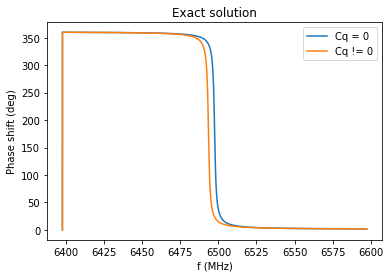

Vertical phase offset at f = 6497.45 MHz: 159.86 deg
Q = 2000
alpha = 0.8
Cq = 2479.3893538625935 aF


In [8]:
#plotting
f = np.linspace(omega_r0/(2*np.pi)-100e6, omega_r0/(2*np.pi)+100e6, 5000)
omega = 2*np.pi*f

if Q<50:
    Z1 = impedance(L, Cp, omega)
    Z2 = impedance(L, Cp+Cq, omega)
    Gamma1 = reflection(Z1, Z_0)
    Gamma2 = reflection(Z2, Z_0)
else:
    Gamma1=reflectionHighQ(omega,omega_r0,Q)
    Gamma2=reflectionHighQ(omega,omega_rq,Q)

phase1 = np.angle(Gamma1,deg=True)
phase2 = np.angle(Gamma2,deg=True)
phase1-=phase1[0]
phase1[phase1<0]+=360
phase2-=phase2[0]
phase2[phase2<0]+=360

#f_cut = 1/(2*np.pi*np.sqrt(L*Cp))
f_cut = omega_r0/(2*np.pi)
f_cut_idx = np.argmin(abs(f - f_cut))

plt.plot(f/1e6, phase1, label='Cq = 0')
plt.plot(f/1e6, phase2, label='Cq != 0')
plt.xlabel('f (MHz)')
plt.ylabel('Phase shift (deg)')
plt.legend()
plt.title('Exact solution')
#plt.xlim([f_cut/1e6 - 10, f_cut/1e6 + 10])
#plt.ylim([-100,100])
plt.show()


print('Vertical phase offset at f = {0:.2f} MHz: {1:.2f} deg'.format(f[f_cut_idx]/1e6, (phase1[f_cut_idx]-phase2[f_cut_idx]))
     )

print('Q = '+str(Q))
print('alpha = '+str(alpha))
print('Cq = ' + str(Cq/1e-18) + ' aF')


157.19012624386957

In [128]:
driveMax(omega_r0/10,5e9)

2.250381412990981e-07

In [176]:
lout*100e-9

6402.8723990372109

In [164]:
lout*1e-6

64.028723990372114